In [68]:
import numpy as np
import sys
sys.path.insert(1,'./../src')
import preposessing
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *
import _tracking as tk
from utils_JK import *
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
sns.set_theme(context='paper',font_scale=1.0, style = 'ticks', color_codes='deep')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
tidssegmentk = preposessing.import_converted_ts(path='./../../5hz_clustered_int/',name='HB141M-2013-12-05_01-27-08.pkl')
tidssegmentkplus1 = preposessing.import_converted_ts(path='./../../5hz_clustered_int/',name='HB141M-2013-12-06_13-25-13.pkl')

No handles with labels found to put in legend.


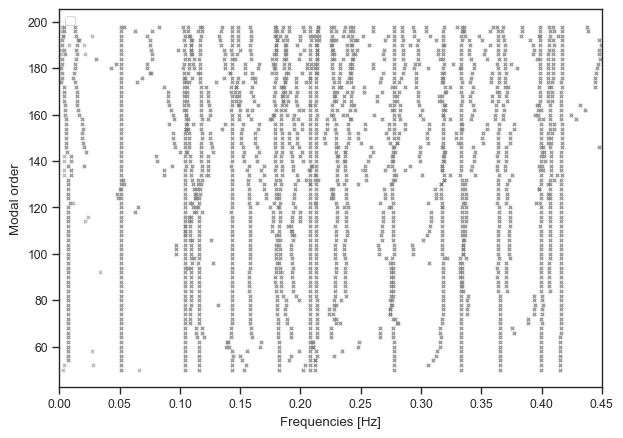

In [6]:
fig = plot_stab_from_KOMA(lambd=tidssegmentk.lambd, xmax=0.45, show_num=False, true_w=False, display=False, figsize = (7,5), xlabel = 'Frequency [Hz]', ylabel = 'Model order')
#fig.savefig('./stabilization_diagram', dpi = 300, bbox_inches = 'tight')

In [110]:

def plot_stab_from_KOMA1(*args,figur_h,axes,sorted_lambds=False,sorted_orders=np.zeros(1),lambd_stab=False,stab_orders=np.zeros(1),lambd=False,all_orders=np.zeros(1),
                        true_w=True,show_num=True,xmin=0,xmax=0.5,info={},display=True,
**kwargs):
    """Returns a figure with the clusters color coded  
    and with lines in between the poles in one cluster
    input: 
    Arguments: 
        sorted_lambds: 2darray
            first axis correspons to each order, second is freqs
            in that order
        sorted_orders: 1d array
            orders tht corresponds to sorted_lambds
        *args: 
            lambd: 2darray
                same type as sorted_lambds. Eigenvalues or 
                frequencies 
            all_orders: 1d array
                orders that correspons to lambd.
            true_w: bool
                True or False
            figsize: (int,int)
            plot_negatives: bool
    
    """
    # import time
    # t0=time.time()
    # print(time.time()-t0)
    #warning for missing data:
    # if not( len(sorted_orders)>1 or len(stab_orders)>1 or
    #         len(all_orders)>1): 
    #     print('No data specified')
    #     return None
    
    # decides if plot is to be saved or displayed interactivly:
    if display:
        matplotlib.use('tkagg')  
    else:
        matplotlib.use('module://matplotlib_inline.backend_inline')

    #create figure and plot scatter

    if 'figsize' in kwargs.keys():
        fig_s=kwargs['figsize']
    else:
        fig_s=(9,9)
    #checks if color should be according to macs
    mac_colors=False
    if 'phi_auto' in kwargs.keys():
        phi_auto=kwargs['phi_auto']
        mac_colors=True

    damping_abs_colors=False
    if 'xi_auto_abs' in kwargs.keys():
        xi_auto=kwargs['xi_auto_abs']
        damping_abs_colors=True

    damping_rel_colors=False
    if 'xi_auto_rel' in kwargs.keys():
        xi_auto=kwargs['xi_auto_rel']
        damping_rel_colors=True

                #creating figure
    #figur_h=plt.figure(figsize=fig_s,dpi=100)
    #axes=figur_h.add_subplot(1,1,1)
    s_dot=fig_s[1]*2

    #The analythical freqs: 

    if true_w:
        
        true_w=np.array([0.052,0.105,0.119,0.142,0.183,0.206,0.212,
                                0.276,0.318,0.331,0.374,0.401])
        
        
        true_cable_modes=np.array([0.23,0.418])
        lab=0
        for w in true_w:
            if lab==0:
                axes.axvline(w,linestyle='--',
                             label='Known freqs',zorder=-1)
            else: 
                axes.axvline(w,linestyle='--',zorder=-1)

            lab=1
        lab=0
        for w in true_cable_modes:
            if lab==0:
                axes.axvline(w,linestyle='--',color='red',alpha=0.7,
                             label='Known freqs with cable',zorder=-1)
            else: 
                axes.axvline(w,linestyle='--',color='red',alpha=0.7,zorder=-1)

            lab=1
    # plotting all the discarded poles: 

    # print('start ',time.time()-t0)
    if lambd != None:
        lambd=np.array(lambd,dtype=object)
        step=int((len(lambd[-1])-len(lambd[0]))/(len(lambd)-1))
        orders=np.arange(len(lambd[0]),len(lambd[-1])+step,step)
        os=np.repeat(orders,orders)
        col='grey'
        axes.scatter(np.hstack(np.abs(lambd))/(2*np.pi),
                     os,color=col,marker='x',s=s_dot*0.5,alpha=0.5)
    # print('lambd ferdig ',time.time()-t0)

    #plotting the poles that were deemed stable: 
    if len(stab_orders)>1:
        col='green'
        axes.scatter((np.abs(lambd_stab))/(2*np.pi),
        stab_orders,color=col,
                marker='.',s=s_dot*1.3)
    # print('stab ferdig ',time.time()-t0)

    #plotting the poles to keep, and the lines between them
    min=1000
    count=0
    if len(sorted_orders)>1:
        for i in sorted_orders:
            for j in i:
                if j<min:
                    min=j
        # Make an arrays of colors. 

        if mac_colors:

            hsv = matplotlib.cm.get_cmap('hsv', 1024)
            newcolors = hsv(np.linspace(-0.1, 0.21, 20))
            green = np.array([0.1, 0.8, .1, 1])
            newcolors[-1:, :] = green
            newcmp = matplotlib.colors.ListedColormap(newcolors)

        if damping_abs_colors or damping_rel_colors: 
            hsv = matplotlib.cm.get_cmap('hsv', 1024)
            newcolors = hsv(np.hstack((
                np.linspace(0, 0.15, 100),np.linspace(0.25,5,100))))
            black = np.array([0, 0, 0, 1])
            i=111
            purp=newcolors[i]
            newcolors[i:,:]=purp
            newcolors[90:100, :] = black

            newcmp = matplotlib.colors.ListedColormap(newcolors)


        else: 
            count=0
            colors=[]
            num=len(sorted_lambds)+8
            root=int(num**(1/3))
            root_rest=int(num/root**2)+1
            colors=[]
            for r in range(root):
                for g in range(root):
                    for b in range(root_rest): 
                        colors.append([r/root,g/root,b/root_rest])
            random.shuffle(colors)
            colors = []

            for color, colorcode in mcolors.TABLEAU_COLORS.items():
                colors.append(color)

            for i in range(num-len(colors)):
                colors.append('tab:green')

        #plotting: 

        just=4
        for i,order_i in enumerate(sorted_orders):
            freq_i=sorted_lambds[i]
            
            size=s_dot*1.2
            if mac_colors:
                cluster=phi_auto[i]
                ref_mode=np.median(cluster,axis=1)
                macs=np.zeros(len(cluster[0]))
                for j in range(len(cluster[0])):
                    phi=cluster[:,j]
                    macs[j]=MAC(phi,ref_mode)
                
                order_arr=np.ones_like(freq_i)*order_i

                axes.plot(np.abs(freq_i)/(2*np.pi),order_arr,
                color='black',linewidth=size/25,zorder=-1)

                scat=axes.scatter(np.abs(freq_i)/(2*np.pi),order_i,marker='s',
                c=macs,cmap=newcmp,s=size,vmin=0,vmax=1)
                if i==0:
                    figur_h.colorbar(scat,ax=axes,location='top',
                                    shrink=0.5,pad=0,aspect=40
                                    ,label='MAC relative to each '+ 
                                    'clusters median mode shape')

            elif damping_abs_colors:
                cluster=xi_auto[i]
                # ref_mode=np.median(cluster)
                # macs=np.zeros(len(cluster[0]))
                # for j in range(len(cluster[0])):
                #     phi=cluster[:,j]
                #     macs[j]=MAC(phi,ref_mode)
                
                order_arr=np.ones_like(freq_i)*order_i

                axes.plot(np.abs(freq_i)/(2*np.pi),order_arr,
                color='black',linewidth=size/25,zorder=-1)

                scat=axes.scatter(np.abs(freq_i)/(2*np.pi),order_i,marker='s',
                c=cluster,cmap=newcmp,s=size,vmin=-1,vmax=1)
                
                #----------------
                #annotation of absolute damping
                for k,freq in enumerate(freq_i):
                    xi=round(cluster[k],3)
                    if xi<0.01:
                        xi_str=str(xi)
                        axes.annotate(xi_str,(np.abs(freq)/(2*np.pi),order_arr[k]),textcoords=('offset pixels'),xytext=(6,-3),fontsize=size/3)
                        



                
                #--------------

                if i==0:
                    figur_h.colorbar(scat,ax=axes,location='top',
                                    shrink=0.5,pad=0,aspect=40
                                    ,label='Absolute damping value in'+ 
                                    'pole')

            else: 
                col=colors[i]
                order_arr=np.ones_like(freq_i)*order_i
                axes.scatter(np.abs(freq_i)/(2*np.pi),order_i,marker='s',
                color=col,s=size)
                axes.plot(np.abs(freq_i)/(2*np.pi),order_arr,
                color=col,linewidth=size/25)

            # creating numberboxes to number the clusters
            if show_num:
                count+=1
                props = dict(boxstyle='round', facecolor='wheat',
                 alpha=0.8)
                try:
                    if np.abs(freq_i[0]-sorted_lambds[i-1][0])<0.05:
                        just+=3.5
                    else:
                        just=4
                except IndexError:
                    pass

                axes.plot([freq_i[0]/(2*np.pi),
                freq_i[0]/(2*np.pi)],
                [order_i[0],min-just]
                ,color='grey',linestyle='--',
                linewidth=size/80)
                axes.text(freq_i[0]/(2*np.pi),
                min-just,str(count),fontsize=8,bbox=props)
            else: 
                count=i

    # print('cluster ferdig ',time.time()-t0)
    #adding the infobox if there are any info to display 
    keys=info.keys()
    if len(keys)>0:
        info['\n'+r"$\bf{Total\ number\ of\ clusters: }$"]=count
        string=r"$\bf{Parameters\ for\ stable\ poles\ and\ clustering:}$"
        for key in keys: 
            string+='\n'+str(key)+': '+str(info.get(key))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        axes.text(0.7, 0.01, string,
                        transform=axes.transAxes,
                         fontsize=9,ha='left',
                        verticalalignment='bottom', bbox=props,
                        clip_on=True)
        axes.legend(loc=(0.5,0.01))
    else:
        axes.legend(loc='upper left')
        pass
    
    #fixing the limits
    axes.set_xlim(xmin,xmax)
    axes.set_ylabel('Model order')
    axes.set_xlabel('Frequency [Hz]')
    # plt.tight_layout() 
    if display:
        plt.subplots_adjust(left=0.1, bottom=0.1,
                right=0.95, top=0.95, wspace=0, hspace=0)
        mng = plt.get_current_fig_manager()
        mng.window.state('zoomed')
    # print('ferdig ',time.time()-t0)
    #return figur_h, axes

In [52]:
lambd=tidssegmentk.lambd
lambd_stab=tidssegmentk.lambd_stab
sorted_lambds=tidssegmentk.lambds_n_auto
sorted_orders=tidssegmentk.order_auto
stab_orders=tidssegmentk.orders_stab
phi_auto=tidssegmentk.phi_auto
xi_auto=tidssegmentk.xi_auto

lambd1=tidssegmentkplus1.lambd
lambd_stab1=tidssegmentkplus1.lambd_stab
sorted_lambds1=tidssegmentkplus1.lambds_n_auto
sorted_orders1=tidssegmentkplus1.order_auto
stab_orders1=tidssegmentkplus1.orders_stab
phi_auto1=tidssegmentkplus1.phi_auto
xi_auto1=tidssegmentkplus1.xi_auto

In [91]:
colors = []

for color, colorcode in mcolors.TABLEAU_COLORS.items():
    colors.append(color)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


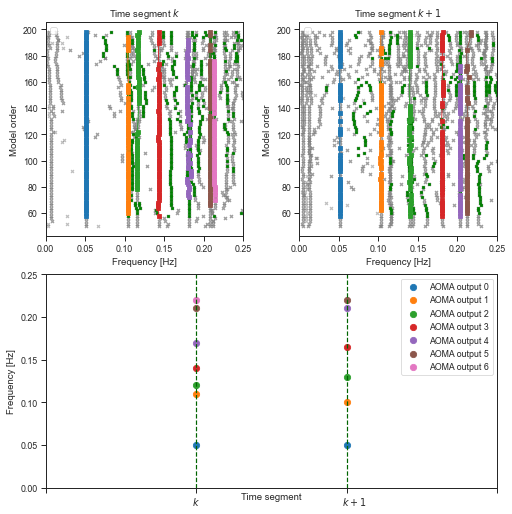

In [115]:
fig = plt.figure(constrained_layout = True, figsize = (7,7))

gs = GridSpec(2, 2, figure=fig)
ax3 = fig.add_subplot(gs[1, :])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plot_stab_from_KOMA1(figur_h = fig, axes = ax1,sorted_lambds=sorted_lambds,
                            sorted_orders=sorted_orders,lambd_stab=lambd_stab,
                            stab_orders=stab_orders, lambd=lambd,
                            true_w=False,show_num=False,xmin=0,
                            xmax=0.25,info={},display=False)

plot_stab_from_KOMA1(figur_h = fig, axes = ax2,sorted_lambds=sorted_lambds1,
                            sorted_orders=sorted_orders1,lambd_stab=lambd_stab1,
                            stab_orders=stab_orders1, lambd=lambd1,
                            true_w=False,show_num=False,xmin=0,
                            xmax=0.25,info={},display=False)

ax1.set_title('Time segment $k$')
ax2.set_title('Time segment $k + 1$')

ax3.set_xticks(np.arange(0,4))
ax3.tick_params(labelbottom=False, labelleft=True)
ax3.annotate('$k$', xy = (1, 0), xytext=((0.97, -0.02)))
ax3.annotate('$k+1$', xy = (2, 0), xytext=((1.97, -0.02)))
ax3.plot([1,1],[0,1], color = 'darkgreen', linestyle='dashed')
ax3.plot([2,2],[0,1], color = 'darkgreen', linestyle='dashed')
ax3.set_xlim(0, 3)
ax3.set_xlabel('Time segment')
ax3.set_ylabel('Frequency [Hz]')
ax3.set_ylim(0,0.25)

freqsk = np.array([0.05, 0.11, 0.12 , 0.14, 0.17, 0.21,0.22])
freqskplus1 = np.array([0.05, 0.10, 0.13, 0.165, 0.21, 0.22])

for i, f in enumerate(freqsk):
    ax3.scatter(1, f,color = colors[i], s = 40, label = 'AOMA output {}'.format(i))

for i, f in enumerate(freqskplus1):
    ax3.scatter(2, f, color = colors[i], s = 40)

ax3.legend()

fig.savefig('./tracking_illustration', dpi = 400, bbox_inches = 'tight')